# Topic:
* Implementing VGG16 in Tensorflow with CIFAR-10 dataset.
  * 訓練的過程
    * Batch size = 1200
    * TRAINING_STEPS=6000
    * 所以 training 時所用到的資料量為 1200*6000 張圖片
  * 訓練出來的效果
    * 此例的 accuracy 為 `Average Testing Accuracy = 0.80`.
  * 以此例的 VGG16 模型(以VGG_Train來替代) 與之前 [vgg16_pretrained_predict.ipynb](vgg16/vgg16_pretrained_predict.ipynb)(在此用 VGG16_Pre 替代) 的比較
    * 均有用到 dropout 機制
    * VGG_Train 在每一個 hidden layer，都有做 batch normalization
    * VGG16_Pre 在 training 前先將 values in image 減去 mean value, VGG16_Pre 則無。是否因為在每一層中均有做 batch normalization，所以不需這個步驟。
    * Convolution 是一致的：
      * kernel size = 3x3, stride = 1
    * Pooling 並不一致：
      * VGG16_Pre: 固定，kernel size = 2x2, stride = 2
      * VGG16_Train: 
        * pool1: kernel size = 3x3, stride = 1
        * others: kernel size = 3x3, stride = 2
  * 在 training procedure 中的 accuracy 是由 train dataset 算出來的，不客觀。應該採用獨立於 training procedure 中的 dataset (ex: test dataset) 來做 accuracy 才是。
    * 較正確的作法應該是將 train 
    * 但這應該不會影響到 training procedure 的正確率。因為 training procedure 中是用 loss 來修正權重的，而非 accuracy。
* ToDo
  * 用整個 test dataset，算出目前的 accuracy (Done)
    * vgg_eval()
  * 是否該將 CIFAR-10 的 dataset (Halt)。`應該不會影響 training procedure 的結果，因為是用 lost 來修正權重的。`
    * 將 train dataset 分割成 90% train + 10% validate
    * test dataset 則用在最後，評做整體 accuracy 之用
    * 如此將 test dataset 隔離於 training procedure 之外，對於 accuracy 較為客觀
  * 用 VGG_Pre 的 mode 做一次完整的 training，比較其結果。

# Reference:
* [使用 Tensorflow 實現類 VGG model 訓練 Cifar10 數據集](http://arbu00.blogspot.com/2018/03/7-tensorflowvgg-model-cifar10.html)
* [Ashing00/Tensorflow_VGG](https://github.com/Ashing00/Tensorflow_VGG)
  * vgg_inference.py
    * VGG16 Class
  * vgg_train.py
    * Training Procedure

# [The CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html)
* 我們使用的是 CIFAR-10 binary version (suitable for C programs)。
  * The binary version contains the files data_batch_1.bin, data_batch_2.bin, ..., data_batch_5.bin, as well as test_batch.bin. Each of these files is formatted as follows:
```
		<1 x label><3072 x pixel>
		...
		<1 x label><3072 x pixel>
```
  * In other words, the first byte is the label of the first image, which is a number in the range 0-9. The next 3072 bytes are the values of the pixels of the image. The first 1024 bytes are the red channel values, the next 1024 the green, and the final 1024 the blue. The values are stored in row-major order, so the first 32 bytes are the red channel values of the first row of the image. 
  * Each file contains 10000 such 3073-byte "rows" of images, although there is nothing delimiting the rows. Therefore each file should be exactly 30730000 bytes long. 
  * There is another file, called batches.meta.txt. This is an ASCII file that maps numeric labels in the range 0-9 to meaningful class names. It is merely a list of the 10 class names, one per row. The class name on row i corresponds to numeric label i.

In [1]:
import os
print(os.getcwd())

/home/ryanyao/work/my_ml_study/TensorFlow_Study/vgg16/vgg16_cifar10_train


### Download CIFAR-10 Dataset (binary version)
* Move it to you source path

In [2]:
# !../get_cifar10.sh

In [3]:
%matplotlib inline
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import struct
import numpy as np
from matplotlib import pyplot as plt

import cv2,csv
import vgg_inference

data_dir = "../../../data/"
extract_folder = 'cifar-10-batches-bin'

### encode_labels( y, k)
* 將 label 轉成 one-shot 的形式
* ex: 以此 10 分類來說，0 <= label <=9。若 label = 3，則其 one-shot 形式為 [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [4]:
def encode_labels( y, k):
	"""Encode labels into one-hot representation
	"""
	onehot = np.zeros((y.shape[0],k ))
	for idx, val in enumerate(y):
		onehot[idx,val] = 1.0  ##idx=0~xxxxx，if val =3 ,表示欄位3要設成1.0
	return onehot

### 以 binary read 的方式讀取 train/test data

In [5]:
def load_train_data(n):			#n=1,2..5,data_batch_1.bin ~data_batch_5.bin
	"""Load Cifar10 data from `path`"""
	images_path = os.path.join(data_dir, extract_folder, 'data_batch_{}.bin'.format(n)) 
	with open(images_path, 'rb') as imgpath:
		images = np.fromfile(imgpath, dtype=np.uint8)
	return images
	
def load_test_data():			#test_batch
	"""Load Cifar10 test data from `path`"""
	test_path = os.path.join(data_dir, extract_folder, 'test_batch.bin') 
	with open(test_path, 'rb') as testpath:
		test_img = np.fromfile(testpath, dtype=np.uint8)
	return test_img	

### 參數設定

In [6]:
# Parameters
MODEL_SAVE_PATH = "./vgg/"
MODEL_NAME = "vgg_cifar_model"
learning_rate = 0.001
BATCH_SIZE = 120
display_step = 100
TRAINING_STEPS=6000
# Network Parameters
n_input = 3072 # cifar data input (img shape: 32x32x3)
n_classes = 10 # cifar10 total classes (0-9 )
dropout = 0.60# Dropout, probability to keep units

### Training 程序
* shuffle
  * 用來控制在 training 過程中，取 train set 的順序是循序或是隨機選取 (隨機選取的順序存在 train_idx)
* vgg_inference
  * 是 VGG16 model，實作在 vgg_inference.py
* 過程中，批次處理 training，並每隔特定次數 (TRAINING_STEPS=6000) 記錄下 (loss, accuracy) 於結整後顯示。

In [7]:
def train(X_train,y_train_lable):
	shuffle=True
	batch_idx=0
	batch_len =int( X_train.shape[0]/BATCH_SIZE)
	print("batch_len=", batch_len) # 50000/120 = 416.6 => 416
	train_loss=[]
	train_acc=[]
	train_idx=np.random.permutation(batch_len)#打散btach_len=500 group

	# tf Graph input
	x_ = tf.placeholder(tf.float32, [None, n_input])	
	y = tf.placeholder(tf.float32, [None, n_classes])
	keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)
	x = tf.reshape(x_, shape=[-1, 32, 32, 3])

	# Construct model
	pred =vgg_inference.inference(x,  keep_prob)

	# Define loss and optimizer
	cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
	optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
	#optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)
	#GradientDescentOptimizer
	# Evaluate model
	correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
	accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

	# 初始化TensorFlow持久化類。
	saver = tf.train.Saver()
	# Initializing the variables
	init = tf.global_variables_initializer()

	# Launch the graph
	with tf.Session() as sess:
		sess.run(init)
		step = 1
		print ("Start  training!")
		# Keep training until reach max iterations:
		while step	< TRAINING_STEPS:
			#batch_xs, batch_ys = mnist.train.next_batch(BATCH_SIZE)
			if shuffle==True:
				batch_shuffle_idx=train_idx[batch_idx]
				batch_xs=X_train[batch_shuffle_idx*BATCH_SIZE:batch_shuffle_idx*BATCH_SIZE+BATCH_SIZE]
				batch_ys=y_train_lable[batch_shuffle_idx*BATCH_SIZE:batch_shuffle_idx*BATCH_SIZE+BATCH_SIZE]	
			else:
				batch_xs=X_train[batch_idx*BATCH_SIZE:batch_idx*BATCH_SIZE+BATCH_SIZE]
				batch_ys=y_train_lable[batch_idx*BATCH_SIZE:batch_idx*BATCH_SIZE+BATCH_SIZE]
		
			if batch_idx<batch_len:
				batch_idx+=1
				if batch_idx==batch_len:
					batch_idx=0
			else:
				batch_idx=0
			# Ryan: why need the reshape?
			reshaped_xs = np.reshape(batch_xs, (
					BATCH_SIZE,
					32,
					32,
					3))
			
			# Run optimization op (backprop)
			sess.run(optimizer, feed_dict={x: reshaped_xs, y: batch_ys,
										keep_prob: dropout})
			# Calculate batch loss and accuracy
			loss, acc = sess.run([cost, accuracy], feed_dict={x: reshaped_xs,
																y: batch_ys,
																keep_prob: 1.})
			train_loss.append(loss)
			train_acc.append(acc)
			if step % display_step == 0:
				print("Step: " + str(step) + ", Minibatch Loss= " + \
					"{:.6f}".format(loss) + ", Training Accuracy= " + \
					"{:.5f}".format(acc))
			step += 1
		print("Optimization Finished!")
		print("Save model...")
		#saver.save(sess, "./vgg/vgg_model")
		saver.save(sess, os.path.join(MODEL_SAVE_PATH, MODEL_NAME))
		
		plt.subplot(1,2,1)
		plt.plot(train_loss)
		plt.xlabel('Iter')
		plt.ylabel('loss')
		plt.title('lr=%f, ti=%d, bs=%d' % (learning_rate, TRAINING_STEPS, BATCH_SIZE))
		#plt.tight_layout()

		plt.subplot(1,2,2)
		plt.plot(train_acc)
		plt.xlabel('Iter')
		plt.ylabel('accuracy')
		plt.title('lr=%f, ti=%d, bs=%d' % (learning_rate, TRAINING_STEPS, BATCH_SIZE))
		#plt.tight_layout()
		plt.savefig('vgg_cifar10_acc.jpg', dpi=200)
		plt.show()				

### 主程序
* X_train_image
  * 一開始其 shape = (50000, 3073)，後來利用 np.delete() 將 lable 欄位移除，所以剩下 (50000, 3072)
  * 所有的 train set, 共有 5000 筆。所以其 shape = (50000, 3072)
    * 其中有一段，我們將 train_image 由 (50000, 3, 32, 32) trans position to ((50000, 32, 32, 3)，是為了符合 VGG16 原本的 data layout。
    * CIFAR-10 data layout of a picture is (3, 32, 32) = (channel, length, width)
    * VGG16 data layout of a picture is (224, 224, 3)= (length, width, channel)
  * 有需要 trans position 嗎? 因為這是完整的訓練，跟原本 VGG16 從 ImageNet 取得的 data layout of picture 是無相關的?
    * ToDo (Halt)
      * `不要做 trans position，再試一次看結果如何?`
* X_train_label
  * 獨立取出的 lable 值放至此，初始時其 shape = (50000, )
  * 經過 one-shot 處理後，其 shape= (50000, 10)
* train(X_train_image,X_train_label)
  * 進行 training procedure

(30730000,)
(153650000,)
y_train_lable.shape= (50000, 3072)
(50000,)
y_train_lable.shape= (50000, 10)
batch_len= 416
layer1-conv1/Relu   [None, 32, 32, 64]
layer1-conv1/Relu_1   [None, 32, 32, 64]
layer1-conv1/pool1   [None, 32, 32, 64]
layer1-conv2/Relu   [None, 32, 32, 128]
layer1-conv2/Relu_1   [None, 32, 32, 128]
layer1-conv2/pool2   [None, 16, 16, 128]
layer3-conv3/Relu   [None, 16, 16, 256]
layer3-conv3/Relu_1   [None, 16, 16, 256]
layer3-conv3/Relu_2   [None, 16, 16, 256]
layer3-conv3/pool3   [None, 8, 8, 256]
layer4-conv4/Relu   [None, 8, 8, 512]
layer4-conv4/Relu_1   [None, 8, 8, 512]
layer4-conv4/Relu_2   [None, 8, 8, 512]
layer4-conv4/pool4   [None, 4, 4, 512]
layer5-conv5/Relu   [None, 4, 4, 512]
layer5-conv5/Relu_1   [None, 4, 4, 512]
layer5-conv5/Relu_2   [None, 4, 4, 512]
layer5-conv5/pool5   [None, 2, 2, 512]
layer6-fc1/Relu   [None, 4096]
layer7-fc2/Relu   [None, 4096]
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the

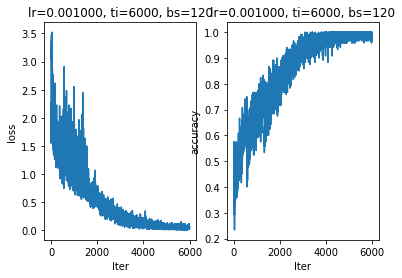

In [8]:
def vgg_train(argv=None):

	##Load Cifar-10 train image and label	
	X_train_image1 = load_train_data(1)	#load data_batch_1.bin
	X_train_image2 = load_train_data(2)	#load data_batch_2.bin
	X_train_image3 = load_train_data(3)	#load data_batch_3.bin
	X_train_image4 = load_train_data(4)	#load data_batch_4.bin
	X_train_image5 = load_train_data(5)	#load data_batch_5.bin
	print(X_train_image1.shape) # (30730000,)
	
	X_train_image=np.concatenate((X_train_image1,X_train_image2,X_train_image3,X_train_image4,X_train_image5),axis=0)
	print(X_train_image.shape) # (153650000,)
	
	#reshape to (50000,3073)
	#in one Row ,the 1st byte is the label,other 3072byte =1024 Red +1024 green +1024 blue ch data
	X_train_image = X_train_image.reshape(-1,3073)
	tempA = X_train_image.copy()
	X_train_image = np.delete(X_train_image, 0, 1) # delete 1st column data. (obj=0, axis=1)
	X_train_image = X_train_image.reshape(-1,3,32,32)  # reshape to (50000,3,32,32)
	X_train_image = X_train_image.transpose([0, 2, 3, 1])	# transfer to (50000,32,32,3)
	X_train_image = X_train_image.reshape(-1,3072)  # (50000, 3072)

	#split to 3073 col,the first column is the label.
	tempA=np.hsplit(tempA,3073)	
	X_train_label=np.asarray(tempA[0])
	X_train_label=X_train_label.reshape([50000,]) # (50000,)

	print("y_train_lable.shape=", X_train_image.shape)	
	print(X_train_label.shape)	
	#print(X_train_label[0:50])	
	

	X_train_label = encode_labels(X_train_label,10)
	print("y_train_lable.shape=",X_train_label.shape)
	#print(X_train_label[0:50])	
	##============================
	
	train(X_train_image,X_train_label)

vgg_train()

### Validate with full test dataset
* 上例的 accuracy 是由 train dataset 計算出來的，不客觀。
* 用以下 vgg_eval() 來計算目前 trained VGG_Train，並以 test dataset 為 input。

In [9]:
def evaluate(X_test,y_test_lable):
	with tf.Graph().as_default() as g:
	
		# 定義輸出為4維矩陣的placeholder
		x_ = tf.placeholder(tf.float32, [None, n_input])	
		x = tf.reshape(x_, shape=[-1, 32, 32, 3])
		y = tf.placeholder(tf.float32, [None, n_classes])
	
		# Construct model
		pred = vgg_inference.inference(x, 1)     #dropout=1

		# Evaluate model
		correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
		accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
	
		test_batch_len =int( X_test.shape[0]/BATCH_SIZE)
		test_acc=[]
		
		test_xs = np.reshape(X_test, (
					X_test.shape[0],
					32,
					32,
					3))
		
		batchsize = BATCH_SIZE
	
		# 'Saver' op to save and restore all the variables
		saver = tf.train.Saver()
		with tf.Session() as sess:
			saver.restore(sess,"./vgg/vgg_cifar_model")

			for i in range(test_batch_len):
				temp_acc= sess.run(accuracy, feed_dict={x: test_xs[batchsize*i:batchsize*i+batchsize], y: y_test_lable[batchsize*i:batchsize*i+batchsize]})
				test_acc.append(temp_acc)
				print ("Test  batch ",i,":Testing Accuracy:",temp_acc)	

			t_acc=tf.reduce_mean(tf.cast(test_acc, tf.float32))	
			print("Average Testing Accuracy=",sess.run(t_acc))
			return

def vgg_eval(argv=None):

	##Load Cifar-10 test image  and label	
	X_test_image = load_test_data()	#load test_batch.bin
	#reshape to (10000,3073)
	#in one Row ,the 1st byte is the label,other 3072byte =1024 Red +1024 green +1024 blue ch data
	X_test_image=X_test_image.reshape(-1,3073)
	tempA=X_test_image.copy()
	X_test_image=np.delete(X_test_image, 0, 1) #delete 1st column data
	X_test_image=X_test_image.reshape(-1,3,32,32)  #(1000,3,32,32)
	X_test_image = X_test_image.transpose([0, 2, 3, 1])	#transfer to (10000,32,32,3)
	X_test_image=X_test_image.reshape(-1,3072)  #(50000,3,32,32)

	#split to 3073 col,the first column is the label.
	tempA=np.hsplit(tempA,3073)	
	X_test_label=np.asarray(tempA[0])
	X_test_label=X_test_label.reshape([10000,])

	
	#mms=MinMaxScaler()
	#X_test_image=mms.fit_transform(X_test_image)
	
	X_test_label = encode_labels(X_test_label,10)
	
	
	print("X_test_image.shape=",X_test_image.shape)	
	print("X_test_label.shape=",X_test_label.shape)
	print(X_test_label[0:5])	
	

	
	evaluate(X_test_image,X_test_label)

vgg_eval()

X_test_image.shape= (10000, 3072)
X_test_label.shape= (10000, 10)
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
layer1-conv1/Relu   [None, 32, 32, 64]
layer1-conv1/Relu_1   [None, 32, 32, 64]
layer1-conv1/pool1   [None, 32, 32, 64]
layer1-conv2/Relu   [None, 32, 32, 128]
layer1-conv2/Relu_1   [None, 32, 32, 128]
layer1-conv2/pool2   [None, 16, 16, 128]
layer3-conv3/Relu   [None, 16, 16, 256]
layer3-conv3/Relu_1   [None, 16, 16, 256]
layer3-conv3/Relu_2   [None, 16, 16, 256]
layer3-conv3/pool3   [None, 8, 8, 256]
layer4-conv4/Relu   [None, 8, 8, 512]
layer4-conv4/Relu_1   [None, 8, 8, 512]
layer4-conv4/Relu_2   [None, 8, 8, 512]
layer4-conv4/pool4   [None, 4, 4, 512]
layer5-conv5/Relu   [None, 4, 4, 512]
layer5-conv5/Relu_1   [None, 4, 4, 512]
layer5-conv5/Relu_2   [None, 4, 4, 512]
layer5-conv5/pool5   [None, 2, 2, 512]
layer6-fc1/Relu   [None, 4096]
layer7-fc2/Relu  

# ToDo

* Batch Normalization
  * [批标准化 (Batch Normalization)](https://morvanzhou.github.io/tutorials/machine-learning/ML-intro/3-08-batch-normalization/)
  * [Batch Normalization](http://violin-tao.blogspot.com/2018/02/ml-batch-normalization.html)
  * [谈谈Tensorflow的Batch Normalization](https://www.jianshu.com/p/0312e04e4e83)

* [tf.nn.softmax_cross_entropy_with_logits](https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits)
  * [tf.nn.softmax_cross_entropy_with_logits的用法](https://blog.csdn.net/mao_xiao_feng/article/details/53382790)

* np.concatenate()
  * [numpy库数组拼接np.concatenate官方文档详解与实例](https://blog.csdn.net/brucewong0516/article/details/79158758)
  
* np.delete()
  * [numpy.delete刪除一列或多列的方法](https://codertw.com/%E7%A8%8B%E5%BC%8F%E8%AA%9E%E8%A8%80/358343/)
  
* np.copy()
  * [numpy 中的 copy 问题详解](https://blog.csdn.net/u010099080/article/details/59111207)
  
* numpy.random.permutation()
  * [numpy.random.permutation](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.random.permutation.html)
  
* tf.train.Saver()
  * [使用 tf.train.Saver()保存模型](https://blog.csdn.net/Jerr__y/article/details/78594494)